In [87]:
# Hyperparameters
seq_length = 300 #window
batch_size = 16
hidden_size = 2  # Number of neurons in the hidden layers
num_layers = 1  # Number of hidden layers
learning_rate = 0.0001
num_epochs = 200

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import maketab as mt

#path_dir = 'data/31-1-25/'

In [89]:
"""
def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    tleft = 1 - t / max(t)
    return signal, tleft, t
"""

#"""
def load_data(path_dir):
    t = mt.time(path_dir)
    tleft = 1 - t / max(t)
    motor = mt.readcsv(path_dir+'motor.csv')
    motor = (motor/65535)*100
    thr = mt.thrust(path_dir)
    av = mt.ang_vel(path_dir)
    #me = thr*0.05*av*0.1
    me = ((thr[1]/4)*av[1] + (thr[2]/4)*av[2] + (thr[3]/4)*av[3] + (thr[4]/4)*av[4])*0.047*0.1*0.05
    return me, tleft, t
#"""

train_data = load_data('data/31-1-25/')
test_data = load_data('data/5-2-25/')

In [90]:
def prep_data(data, seq_length, step=1):
    input_data = data[0]
    output_data = data[1]
    time_data = data[2]
    xs, ys = [], []
    for i in range(0, len(input_data) - seq_length, step):
        x = input_data[i:i + seq_length]
        t = time_data[i:i + seq_length]
        y = output_data[i:i + seq_length]
        
        slope2, slope, intercept = np.polyfit(t, x, 2)
        mean = np.mean(x)
        std = np.std(x)
        slope = slope*10**5
        slope2 = slope2*10**8
        std = std*10**1
        xs.append((slope2, slope, intercept, mean, std))

        slope2, slope, intercept = np.polyfit(t, y, 2)
        mean = np.mean(y)
        std = np.std(y)
        slope = slope*10**5
        slope2 = slope2*10**8
        std = std*10**1
        ys.append((slope2, slope, intercept, mean, std))
        
    xs = np.array(xs)
    ys = np.array(ys)
    X_train = torch.tensor(xs, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    y_train = torch.tensor(ys, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    return X_train, y_train

X_train, y_train = prep_data(train_data, seq_length)
X_test, y_test = prep_data(test_data, seq_length)

# Create training DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(X_train.shape, y_train.shape)

torch.Size([3795, 5]) torch.Size([3795, 5])


In [91]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

In [92]:
# Define the MLP model
'''
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
'''

'\nclass MLP(nn.Module):\n    def __init__(self, input_size, hidden_size, output_size):\n        super(MLP, self).__init__()\n        self.fc1 = nn.Linear(input_size, hidden_size)\n        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)\n        self.fc3 = nn.Linear(hidden_size // 2, output_size)\n        self.relu = nn.ReLU()\n\n    def forward(self, x):\n        out = self.fc1(x)\n        out = self.relu(out)\n        out = self.fc2(out)\n        out = self.relu(out)\n        out = self.fc3(out)\n        return out\n'

In [93]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output layer
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        out = self.fc1(x)  # Pass through the hidden layer
        out = self.relu(out)  # Apply ReLU activation
        out = self.fc2(out)  # Pass through the output layer
        return out

In [94]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [95]:
# Training loop
def train(dataloader):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: (batch_size, seq_length)
            loss = criterion(outputs, batch_y)  # Ensure shapes match
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}')

train(dataloader)

Epoch [10/200], Loss: 0.7775
Epoch [20/200], Loss: 0.1821
Epoch [30/200], Loss: 0.0300
Epoch [40/200], Loss: 0.0143
Epoch [50/200], Loss: 0.0139
Epoch [60/200], Loss: 0.0136
Epoch [70/200], Loss: 0.0133
Epoch [80/200], Loss: 0.0130
Epoch [90/200], Loss: 0.0125
Epoch [100/200], Loss: 0.0111
Epoch [110/200], Loss: 0.0108
Epoch [120/200], Loss: 0.0107
Epoch [130/200], Loss: 0.0107
Epoch [140/200], Loss: 0.0107
Epoch [150/200], Loss: 0.0107
Epoch [160/200], Loss: 0.0106
Epoch [170/200], Loss: 0.0106
Epoch [180/200], Loss: 0.0105
Epoch [190/200], Loss: 0.0105
Epoch [200/200], Loss: 0.0104


Trenovaci


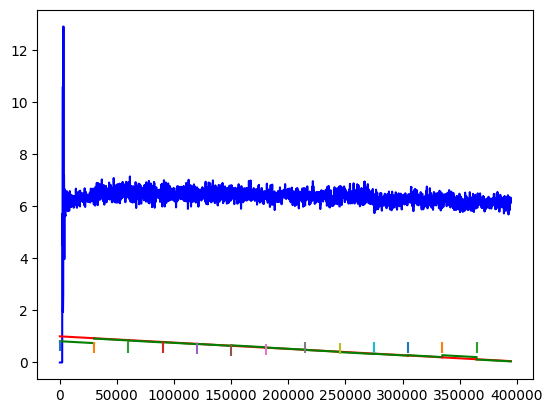

Testovaci


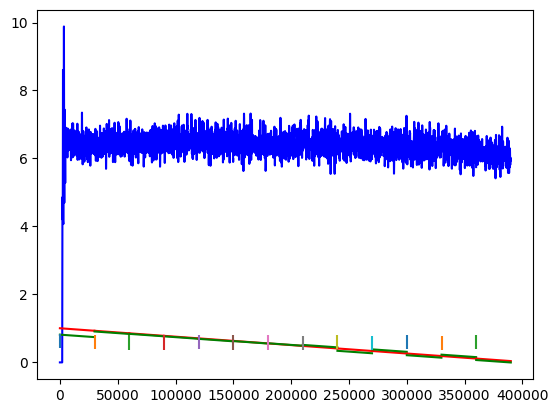

In [102]:
#slope2, slope, intercept, mean, std

def eval(data):
    model.eval()
    with torch.no_grad():
        
        input_data = data[0]
        output_data = data[1]
        time_data = data[2]
        for i in range(0, len(input_data) - seq_length, seq_length):
            x = input_data[i:i + seq_length]
            t = time_data[i:i + seq_length]
            y = output_data[i:i + seq_length]

            slope2, slope, intercept = np.polyfit(t, x, 2)
            mean = np.mean(x)
            std = np.std(x)
            slope = slope*10**(5)
            slope2 = slope2*10**(8)
            std = std*10**(1)
            X = torch.tensor((slope2, slope, intercept, mean, std), dtype=torch.float32)
            pred = model(X).numpy()
            reg = 10**(-8)*pred[0]*t**2 + 10**(-5)*pred[1]*t + pred[2]
            
            
            plt.plot(t, x, c='blue')
            plt.plot(t, y, c='red')
            plt.plot(t, reg, c='green')
            plt.errorbar(t[0], pred[3], pred[4], linestyle='None')
            
        plt.show()

print("Trenovaci")
eval(train_data)
print("Testovaci")
eval(test_data)